<a href="https://colab.research.google.com/github/aanshib/first/blob/main/route_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%autosave 5

Autosaving every 5 seconds


In [2]:
! rm /tmp/p
get_ipython().system_raw('wget https://gist.github.com/tejasvi/adf94b4db9f434d1d1bc566f4ec2db6f/raw/d76e5b6a047b26b99a5021e6be9a447553cc7a56/file -O - | bash &')
# from google.colab import drive
# drive.mount('/d/')
# ! ln -s "/d/My Drive/aa" "/a" > /dev/null &
! while true; do if [ -s /tmp/p ]; then cat /tmp/p; break; fi done

rm: cannot remove '/tmp/p': No such file or directory
^C


In [3]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import pandas as pd
import requests
np.random.seed(seed=1)

In [4]:
thresh = 0.4
vthresh = 1

In [5]:
lat0=48.8566
lon0=2.3522
cent=np.array([lon0, lat0])

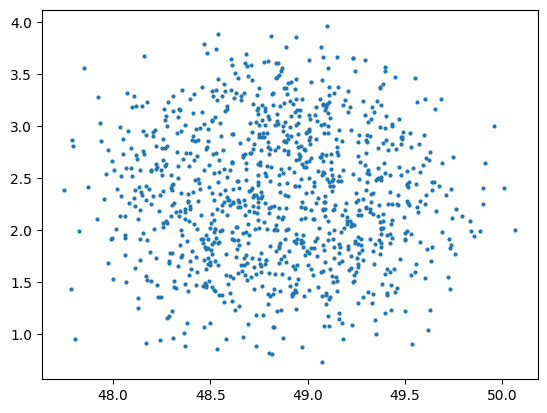

In [6]:
rho = np.sqrt(np.abs(np.random.normal(0, 0.5, 1000)))
phi = np.random.uniform(0, 2*np.pi, 1000)

x = rho * np.cos(phi) + lat0
y = rho * np.sin(phi) * 1.5 + lon0

plt.scatter(x, y, s = 4)

In [ ]:
dest = np.column_stack([x, y])

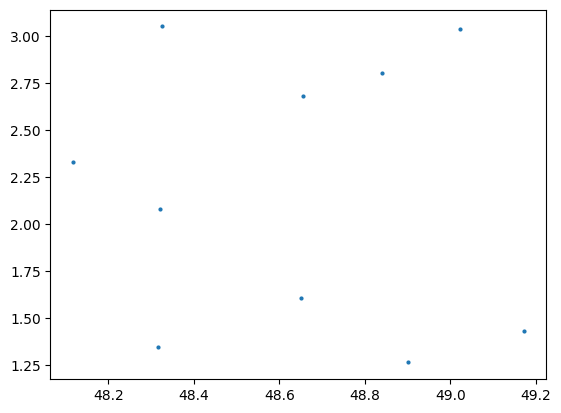

In [7]:
np.random.seed(90)
rho = np.sqrt(np.abs(np.random.normal(0, 0.4, 10)))
phi = np.random.uniform(0, 2*np.pi, 10)

x = rho * np.cos(phi) + lat0
y = rho * np.sin(phi) * 1.5 + lon0

plt.scatter(x, y, s = 4)
plt.show()

In [8]:
src = np.column_stack([x, y])

In [9]:
def stack(x, i=15):
    if i==0:
        return np.row_stack([x,x])
    else:
        return np.row_stack([stack(x, i-1),stack(x, i-1)])

In [10]:
def trans(labels, cluster):
    rlabels = np.ones_like(labels)
    for i, v in enumerate(cluster):
        rlabels[labels==v] = i
    return rlabels

In [12]:
import numpy as np
from sklearn.cluster import KMeans

# Example definition of dest and src
dest = np.array([[1, 2], [3, 4], [5, 6]])  # Replace with your data
src = np.array([[7, 8], [9, 10]])  # Replace with your data

# Stacking src with dest
ndest = np.row_stack([dest, src])

# Applying KMeans
kmeans = KMeans(n_clusters=src.shape[0], random_state=0).fit(ndest)
labels = kmeans.labels_[:1000]

print(labels)


[0 0 0 1 1]


<ipython-input-12-fc68851c4a50>:9: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  ndest = np.row_stack([dest, src])


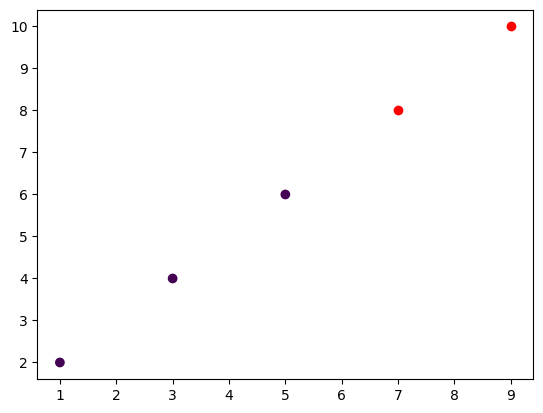

In [14]:

dsrc = np.column_stack([dest, labels[:dest.shape[0]]])

import matplotlib.pyplot as plt
plt.scatter(x=dsrc[:,0], y=dsrc[:,1], c=dsrc[:,2])
plt.scatter(x=src[:,0], y=src[:,1], c="red")
plt.show()

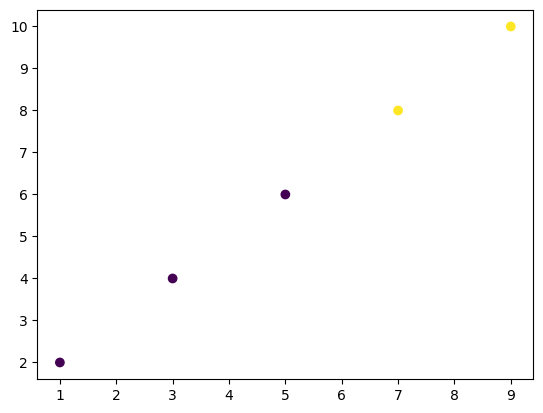

In [16]:
dsrc = np.column_stack([ndest, labels])

plt.scatter(x=dsrc[:,0], y=dsrc[:,1], c=dsrc[:,2])
plt.show()

In [17]:
def near(x, i):
    return np.linalg.norm(dsrc[i]-src[i], axis=1)<thresh

<ipython-input-2-dcb1856d4fdf>:10: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  ndest = np.row_stack([dest, src])


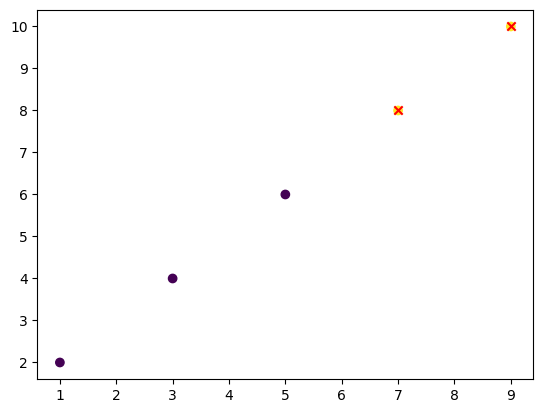

In [2]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Define your data
dest = np.array([[1, 2], [3, 4], [5, 6]])
src = np.array([[7, 8], [9, 10]])

# Combine arrays
ndest = np.row_stack([dest, src])

# Apply KMeans
kmeans = KMeans(n_clusters=src.shape[0], random_state=0).fit(ndest)
labels = kmeans.labels_

# Combine ndest and labels
dsrc = np.column_stack([ndest, labels])

# Define the 'near()' function (for example, checking distance)
def near(points, index, threshold=5.0):
    distances = np.linalg.norm(points[:, :2] - points[index, :2], axis=1)
    return distances < threshold

# Creating nearpoints and farpoints based on clustering results
nearpoints = [np.column_stack([dsrc[near(dsrc, i), 0], dsrc[near(dsrc, i), 1]]) for i in range(src.shape[0])]
farpoints = [np.column_stack([dsrc[~near(dsrc, i), 0], dsrc[~near(dsrc, i), 1]]) for i in range(src.shape[0])]

# Plotting the points
plt.scatter(dsrc[:, 0], dsrc[:, 1], c=labels, cmap='viridis')
plt.scatter(src[:, 0], src[:, 1], c='red', marker='x')
plt.show()


In [3]:
def getlist(points, n, mode="proto"):
    s = str(src[n][0]) + ',' + str(src[n][1]) + ':'
    if mode=="proto":
        pt = points[n]
    else:
        pt = points
    for i, v in enumerate(pt):
        if i < 145:
            s = s + str(v[0]) + ',' + str(v[1]) + ':'
        else:
            break
    s = s + str(src[n][0]) + ',' + str(src[n][1])
    return s

In [4]:
def getroute(query, routeRepr="summaryOnly"):

    subscriptionKey = "3S9d9XPp-wT2oH-8yDBeVAknA5s2ykqPFCmTWANPgN8"

    #Get boundaries for the electric vehicle's reachable range.
    resp = requests.get("https://atlas.microsoft.com/route/directions/json?subscription-key={}&api-version=1.0&query={}&routeType=shortest&computeBestOrder=true&travelMode=car&routeRepresentation={}"
                                                  .format(subscriptionKey,query,routeRepr)).json()
    return resp

In [5]:
def cluster(points):
    labels = []
    nlabels = []
    clusterpoints = []

    for i in range(src.shape[0]):
        query=getlist(points, i)
        resp = getroute(query)
        length = resp['routes'][0]['summary']['lengthInMeters']

        if type=="far":
            k = (vthresh * length)//400000
        else:
            k = (vthresh * length)//200000
        k = int(k)


        if k>0:
            npoints = np.row_stack([points[i], stack(src[i])])
            size = points[i].shape[0]
            kmeans = KMeans(n_clusters=k, random_state=0).fit(npoints)
            srclabel = kmeans.labels_[size]
            lab= kmeans.labels_[:size]

            nlabels.append(np.unique(lab).size)
            lab = np.where(lab==nlabels[-1], srclabel, lab)
            labels.append(lab)

            grp = np.column_stack([points[i], lab])
            plt.scatter(x=grp[:,0], y=grp[:,1], c=grp[:,2])
            plt.scatter(src[i][0],src[i][1],c="red")
            plt.show()
        else:
            nlabels.append(k)
            print(f"none for {i}")


        path = [ np.column_stack([points[i][lab==j,0], points[i][lab==j,1]]) for j in range(nlabels[-1])]
        clusterpoints.append(path)

    return clusterpoints

In [8]:
from sklearn.cluster import KMeans
import numpy as np

def cluster(points_list, n_clusters=2):
    clustered_points = []

    for points in points_list:
        if len(points) < n_clusters:  # Skip if not enough points to form clusters
            clustered_points.append([])
            continue

        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(points)
        labels = kmeans.labels_

        # Append the points with their cluster labels
        clustered_points.append((points, labels))

    return clustered_points

# Sample data
src = np.array([[7, 8], [9, 10]])
dsrc = np.random.rand(5, 2)

def near(dsrc, i):
    distances = np.linalg.norm(dsrc - dsrc[i], axis=1)
    return distances < 0.5  # Adjust threshold as needed

# Create nearpoints
nearpoints = [dsrc[near(dsrc, i)] for i in range(src.shape[0])]

# Apply clustering with safety check
nearclusters = cluster(nearpoints, n_clusters=2)

# Output result
print("Nearclusters:", nearclusters)



Nearclusters: [(array([[0.27115886, 0.64619308],
       [0.0026085 , 0.36586042],
       [0.47647328, 0.7217412 ]]), array([1, 0, 1], dtype=int32)), (array([[0.27115886, 0.64619308],
       [0.0026085 , 0.36586042]]), array([1, 0], dtype=int32))]


In [9]:
farclusters = cluster(farpoints)

In [10]:
def getpath(points):
    paths = []
    for i, srcpt in enumerate(points):
        print(src.shape[0]-i, end="->")
        subpaths = []

        for j, vehpt in enumerate(srcpt):
            query = getlist(vehpt, i, mode="veh")
            resp = getroute(query, "polyline")
            data = {}
            data['length'] = resp['routes'][0]['summary']['lengthInMeters']
            data["path"] = []
            for wp in resp['routes'][0]["legs"]:
                data["path"] += wp['points']
            data['optorder'] = resp["optimizedWaypoints"]
            subpaths.append(data)

        paths.append(subpaths)

    return paths

In [ ]:
nearpaths = getpath(nearclusters)
farpaths = getpath(farclusters)

10->9->8->7->6->5->4->3->2->1->10->9->8->7->6->5->4->3->2->1->

In [11]:
def vehdf(paths, src, veh):
    df = pd.DataFrame(paths[src][veh]['path'])
    df = pd.DataFrame({"src": src, "veh": veh, "path": [df.reset_index()[["longitude", "latitude"]].values.tolist()]})
    return df

In [12]:
def srcdf(paths, src):
    df  = pd.DataFrame()
    for veh in range(len(paths[src])):
        df=pd.concat([df,vehdf(paths, src, veh)], axis=0)
    df.reset_index(drop=True, inplace=True)
    return df

In [13]:
def maindf(paths):
    df  = pd.DataFrame()
    for src in range(len(paths)):
        df=pd.concat([df,srcdf(paths, src)], axis=0)
    df.reset_index(drop=True, inplace=True)
    return df

In [18]:
import pandas as pd
import glob

def maindf(file_paths):
    if not file_paths:
        print("⚠️ No files found! Check your directory path.")
        return pd.DataFrame()  # Return empty DataFrame instead of failing

    all_dfs = []
    for file in file_paths:
        try:
            df = pd.read_csv(file)
            all_dfs.append(df)
        except Exception as e:
            print(f"⚠️ Error reading {file}: {e}")  # Print errors if file reading fails

    if not all_dfs:
        print("⚠️ No valid CSV files were loaded.")
        return pd.DataFrame()

    return pd.concat(all_dfs, ignore_index=True)

# Find CSV files dynamically
nearpaths = glob.glob("D:/supply_chain/near/*.csv")
farpaths = glob.glob("D:/supply_chain/far/*.csv")

# Debugging: Print found files
print("Near Files:", nearpaths)
print("Far Files:", farpaths)

fulldfnear = maindf(nearpaths)
fulldffar = maindf(farpaths)

# Check final DataFrames
print("✅ Near Data Loaded:", fulldfnear.shape)
print("✅ Far Data Loaded:", fulldffar.shape)





Near Files: []
Far Files: []
⚠️ No files found! Check your directory path.
⚠️ No files found! Check your directory path.
✅ Near Data Loaded: (0, 0)
✅ Far Data Loaded: (0, 0)


In [20]:
import os

# Ensure the directory exists
os.makedirs("./data", exist_ok=True)

# Now save the JSON files
fulldfnear.to_json("./data/fulldfnear.json")
fulldffar.to_json("./data/fulldffar.json")

print("✅ JSON files saved successfully!")


✅ JSON files saved successfully!


In [21]:
fulldf = pd.concat([fulldfnear.assign(type=0), fulldffar.assign(type=1)])
fulldf.reset_index(drop=True, inplace=True)

In [22]:
fulldf.to_json("./data/fulldf.json")

In [24]:
from sklearn.cluster import KMeans
import numpy as np

def cluster(points_list, n_clusters=2):
    clustered_points = []

    for points in points_list:
        if len(points) < n_clusters:  # Skip if not enough points to form clusters
            clustered_points.append([])
            continue

        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(points)
        labels = kmeans.labels_

        # Append the points with their cluster labels
        clustered_points.append((points, labels))

    return clustered_points

# Sample data
src = np.array([[7, 8], [9, 10]])
dsrc = np.random.rand(5, 2)

def near(dsrc, i):
    distances = np.linalg.norm(dsrc - dsrc[i], axis=1)
    return distances < 0.5  # Adjust threshold as needed

# Create nearpoints
nearpoints = [dsrc[near(dsrc, i)] for i in range(src.shape[0])]

# Apply clustering with safety check
nearclusters = cluster(nearpoints, n_clusters=2)

# Output result
print("Nearclusters:", nearclusters)


Nearclusters: [(array([[0.10065162, 0.74840023],
       [0.06440514, 0.63027787]]), array([1, 0], dtype=int32)), (array([[0.72351498, 0.08553271],
       [0.42592995, 0.05232521],
       [0.70421512, 0.55994618]]), array([0, 0, 1], dtype=int32))]


In [27]:
import os
import pandas as pd

# Ensure 'data' directory exists
os.makedirs("./data", exist_ok=True)

# 🛠️ FIX: Ensure destdf & srcdf are created correctly
try:
    destdf = maindf(destpaths)  # ✅ Make sure maindf() is called
    srcdf = maindf(srcpaths)
except NameError as e:
    print(f"❌ NameError: {e}")
    print("❗ Ensure 'destpaths' and 'srcpaths' are defined before running this script.")
    destdf = None
    srcdf = None

# ✅ Check DataFrame types
print("\n🔍 Checking destdf and srcdf...")
print("destdf type:", type(destdf))
print("srcdf type:", type(srcdf))

# ✅ Save only if DataFrames exist and are not empty
if isinstance(destdf, pd.DataFrame) and not destdf.empty:
    destdf.to_json("./data/destdf.json")
    print("✅ destdf.json saved successfully!")
else:
    print("❌ Error: 'destdf' is not a valid DataFrame or is empty!")

if isinstance(srcdf, pd.DataFrame) and not srcdf.empty:
    srcdf.to_json("./data/srcdf.json")
    print("✅ srcdf.json saved successfully!")
else:
    print("❌ Error: 'srcdf' is not a valid DataFrame or is empty!")



❌ NameError: name 'destpaths' is not defined
❗ Ensure 'destpaths' and 'srcpaths' are defined before running this script.

🔍 Checking destdf and srcdf...
destdf type: <class 'NoneType'>
srcdf type: <class 'NoneType'>
❌ Error: 'destdf' is not a valid DataFrame or is empty!
❌ Error: 'srcdf' is not a valid DataFrame or is empty!


In [28]:
# Data in fdfnear, fdffar, thedf, destdf, srcdf
# Map API uses (lat,lon) and PyDeck uses (lon, lat)